In [ ]:
!pip install mtcnn
!pip install keras_vggface
!pip install keras_applications
!pip install twilio

     |████████████████████████████████| 2.3MB 9.6MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
     |████████████████████████████████| 481kB 7.4MB/s 
  Created wheel for twilio: filename=twilio-6.59.1-py2.py3-none-any.whl size=1268948 sha256=d95807944b2d20ce42859fad4b68d073c3d5b3373a30fb769168bcdcd579bd1b
  Stored in directory: /root/.cache/pip/wheels/71/f7/c2/4ff5570b626bcd307be61951f1979a03c12d03a157b503e001
Successfully built twilio


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from mtcnn.mtcnn import MTCNN
import cv2
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine
import urllib.request
import requests
import threading
import random

In [ ]:
def face_det_ext(img): 
    face_det=MTCNN()
    faces=face_det.detect_faces(img)
    co=list(faces[0]['box'])
    x1, y1, x2, y2=co[0], co[1], co[0]+co[2], co[1]+co[3]
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255),10)
    cp=img[y1:y2,x1:x2]
    plt.imshow(cp)
    return cp 

def pre_proc(img1):
    img1=cv2.resize(img1, (224,224))
    img1=np.expand_dims(img1, axis=0)
    return img1

def get_model_scores(faces):
    samples=np.array(faces, 'float32')
    samples=preprocess_input(samples, version=2)
    model=VGGFace(model='resnet50',include_top=False,input_shape=(224,224,3), pooling='avg')
    return model.predict(samples)

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from twilio.rest import Client
    
def register():
  ch="y";
  while ch=="y":
    filename = take_photo();
    print('Saved to {}'.format(filename));
    img=plt.imread('/content/photo.jpg');
    img=face_det_ext(img);
    img=pre_proc(img);
    score=get_model_scores(img);
    name=input("Give Name:");
    mobile=input("Enter your Mobile No:")
    scores.append([score,name,mobile]);
    ch=input("Wanna add more faces? (y/n)");

def thingspeak_post(valm):
    val="x"+valm
    URL='https://api.thingspeak.com/update?api_key='
    KEY='PGT5KWK1GDGZULFX'
    HEADER='&field1={}'.format(val)
    NEW_URL=URL+KEY+HEADER
    print(NEW_URL)
    data=urllib.request.urlopen(NEW_URL)
    print(data)

def scan():
  filename = take_photo();
  print('Saved to {}'.format(filename));
  img=plt.imread('/content/photo.jpg');
  plt.imshow(img);
  img=face_det_ext(img);
  img=pre_proc(img);
  sc=get_model_scores(img);
  flag=0;
  for score in scores:
    if(cosine(score[0],sc)<0.4):
      print('Hi',score[1]);
      flag=1;
      k="y"
      break
  if(flag==0):
    print("Wait a minute! Who are you?")
    k="n"
    client = Client('AC06bed9af7d55e1512571af4433174a43', '8cc534e15e7171ebce790489a57a6417')
    client.messages.create(from_='+19044585957',
                       to=score[2],
                       body='Unautorized person detected outside your house!')
    print("Message sent to the Authorized User")

  thingspeak_post(k)  

<IPython.core.display.Javascript object>

Saved to photo.jpg
94707712/94694792 [==============================] - 1s 0us/step
Give Name:Abhishek
Enter your Mobile No:+917305899874
Wanna add more faces? (y/n)n


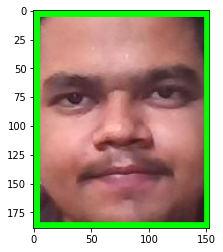

In [ ]:
scores=[]
register()

<IPython.core.display.Javascript object>

Saved to photo.jpg
Wait a minute! Who are you?
Message sent to the Authorized User
https://api.thingspeak.com/update?api_key=PGT5KWK1GDGZULFX&field1=xn


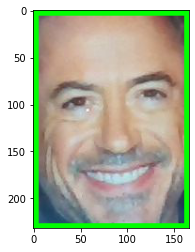

In [ ]:
scan()